In [1]:
# importing packages
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import time
import scipy.integrate as integrate
import pickle

In [2]:
def F_o(t,a,b_p,g,F_b,sd):
    
    b_m = 4.159
    
    p_0 = a/(b_p*b_m*g)
    
    if t < sd:
        
        p = F_b + p_0
        
    else:
        
        p = F_b + (a/(b_p*b_m) + a*(1-1/g)*np.exp(-b_m*(t-sd))/(b_m**2-b_p*b_m) + 
                   (p_0 - a/(b_p*b_m) - a*(1-1/g)/(b_m**2-b_p*b_m))*np.exp(-b_p*(t-sd)))
    
    return p

def F_s(t,t_l,a,b_p,g,F_b,sd):
    
    b_m = 4.159
    
    p_0 = a/(b_p*b_m*g)
    
    p_t_l = (a/(b_p*b_m) + a*(1-1/g)*np.exp(-b_m*(t_l-sd))/(b_m**2-b_p*b_m) + 
             (p_0 - a/(b_p*b_m) - a*(1-1/g)/(b_m**2-b_p*b_m))*np.exp(-b_p*(t_l-sd)))
    
    if t_l < sd:
        
        p = F_b + ((p_0-a/((b_p-b_m)*b_m*g))*np.exp(-b_p*(t-t_l)) + a*np.exp(-b_m*(t-t_l))/((b_p-b_m)*b_m*g))
    
    else:
        
        p = F_b + ((p_t_l + a*(1-(1-1/g)*np.exp(-b_m*(t_l-sd)))/(b_m**2-b_p*b_m))*np.exp(-b_p*(t-t_l)) -
             a*(1-(1-1/g)*np.exp(-b_m*(t_l-sd)))/(b_m**2-b_p*b_m)*np.exp(-b_m*(t-t_l)))
        
    return p

def f(x,t,alpha,beta,gamma,sigma,k,mu,P_b,F_b,sd):
    
    background = P_b*stats.norm.pdf(x,np.log10(F_b),sigma)
    
    on = (1-P_b)*(1-stats.gamma.cdf(t,k,scale=mu/k))*stats.norm.pdf(x,np.log10(F_o(t,alpha,beta,gamma,F_b,sd)),sigma)
    
    n = np.size(x)
    
    if n == 1:
        f_s = integrate.quad(lambda t_lag: 
                             stats.norm.pdf(x,np.log10(F_s(t,t_lag,alpha,beta,gamma,F_b,sd)),sigma)\
                             *stats.gamma.pdf(t_lag,k,scale=mu/k),0,t)[0]
    else:
        f_s = np.zeros(n)
        for i in np.arange(n):
            f_s[i] = integrate.quad(lambda t_lag: 
                                    stats.norm.pdf(x[i],np.log10(F_s(t,t_lag,alpha,beta,gamma,F_b,sd)),sigma)\
                                    *stats.gamma.pdf(t_lag,k,scale=mu/k),0,t)[0]
    
    silent = (1-P_b)*f_s
    
    F = on + background + silent
    
    return F

In [3]:
def loadData(cloneName):
    
    # reading the csv
    data = pd.read_csv(cloneName+'.csv',header=None)
    
    # converting from data frame to array
    data = data.values
    f_t = data[:,2]
    f_C = np.power(10,data[:,0])
    f_m = np.power(10,data[:,1])
    
    return (f_t,f_C,f_m)

In [4]:
def halfViolinPlotwModel(cloneNames, title, ylims, offGates, fitsFile, returnFig=False):
    
    # assigning min and max y axis lims
    Cit_max_ymin = ylims[0][0]
    Cit_min_ymax = ylims[0][1]
    mCh_max_ymin = ylims[1][0]
    mCh_min_ymax = ylims[1][1]

    # creating the figure
    #fig, ax1 = plt.subplots(figsize=[5,2])
    fig, ax1 = plt.subplots(figsize=[12,6])
    ax2 = ax1.twinx()

    # creating dictionaries to store all the data by day
    Cit_all_data = {}
    mCh_all_data = {}

    # getting the timepoints from the whole dataset
    all_pos = []
    for clone in cloneNames:

        # loading data
        data = loadData(clone)

        # postions vector
        all_pos = np.sort(np.unique(np.concatenate((all_pos,data[0]))))

    for clone in cloneNames:

        # loading data
        data = loadData(clone)

        # postions vector and empty arrays for daily citrine and mcherry
        pos = np.sort(np.unique(data[0]))
        daily_data_C = []
        daily_data_m = []

        # extracting the data for each day into a separate array and adding that array to the daily arrays
        for i in pos:
            ind = data[0] == i
            temp = data[1][ind]
            daily_data_C.append(np.log10(temp))
            temp = data[2][ind]
            daily_data_m.append(np.log10(temp))

        # getting the indicies for the plot relative to the whole dataset
        ind = []
        for i in pos:
            ind.append(np.where(all_pos == i)[0][0])

        # plotting citrine violin plots    
        vplot = ax1.violinplot(daily_data_C,ind,widths=1,showextrema=False)

        # setting colors for citrine and making half plots
        for v in vplot['bodies']:
            m = np.mean(v.get_paths()[0].vertices[:, 0])
            v.get_paths()[0].vertices[:, 0] = np.clip(v.get_paths()[0].vertices[:, 0], -np.inf, m)
            v.set_facecolor('#FFA900')
            v.set_alpha(0.4)

        # plotting mcherry violin plots
        vplot = ax2.violinplot(daily_data_m,ind,widths=1,showextrema=False)

        # setting colors for mcherry and making half plots
        for v in vplot['bodies']:
            m = np.mean(v.get_paths()[0].vertices[:, 0])
            v.get_paths()[0].vertices[:, 0] = np.clip(v.get_paths()[0].vertices[:, 0], m, np.inf)
            v.set_facecolor('#962A2F')
            v.set_alpha(0.4)

        # adding daily data to all data dictionaries
        i = np.size(pos)
        for i in np.arange(i):
            try: 
                tmp_Cit = Cit_all_data[pos[i]]
            except KeyError:
                tmp_Cit = []
            try: 
                tmp_mCh = mCh_all_data[pos[i]]
            except KeyError:
                tmp_mCh = []
            Cit_all_data[pos[i]] = np.concatenate((tmp_Cit,daily_data_C[i]))
            mCh_all_data[pos[i]] = np.concatenate((tmp_mCh,daily_data_m[i]))

    # converting all the daily data into an array
    all_daily_data_C = []
    all_daily_data_m = []
    pos = np.array(list(Cit_all_data.keys()))
    for i in all_pos:
        all_daily_data_C.append(Cit_all_data[i])
        all_daily_data_m.append(mCh_all_data[i])

    # # adding Cit cumulative violin distribution to plot
    # ind = np.arange(np.size(all_pos))
    # vplot = ax1.violinplot(all_daily_data_C,ind,widths=1,showextrema=False)
    # for v in vplot['bodies']:
    #     m = np.mean(v.get_paths()[0].vertices[:, 0])
    #     v.get_paths()[0].vertices[:, 0] = np.clip(v.get_paths()[0].vertices[:, 0], -np.inf, m)
    #     v.set_facecolor('none')
    #     v.set_edgecolor('k')
    #     v.set_alpha(1)

    # # adding mCh cumulative violin distribution to plot    
    # vplot = ax2.violinplot(all_daily_data_m,ind,widths=1,showextrema=False)
    # for v in vplot['bodies']:
    #     m = np.mean(v.get_paths()[0].vertices[:, 0])
    #     v.get_paths()[0].vertices[:, 0] = np.clip(v.get_paths()[0].vertices[:, 0], m, np.inf)
    #     v.set_facecolor('none')
    #     v.set_edgecolor('k')
    #     v.set_alpha(1)

    # using all the data at each time point to calculate the modes for cit and mch
    Cit_modes = []
    mCh_modes = []
    for i in all_pos:
        Cit_modes.append(float(stats.mode(np.round(Cit_all_data[i],2))[0]))
        mCh_modes.append(float(stats.mode(np.round(mCh_all_data[i],2))[0]))

    # finding the max modes for Cit and mCh for top alignment
    Cit_mode_max = max(Cit_modes)
    mCh_mode_max = max(mCh_modes)

    # setting the bottom alignment to the off gates
    Cit_off_gate = np.log10(offGates[0])
    mCh_off_gate = np.log10(offGates[1])

#     # drawing a line through the off gate, adding "ON" and "OFF" labels
#     ax1.plot([min(ind)-1,max(ind)+1],[Cit_off_gate,Cit_off_gate],'k--',lw=1.2,zorder=20)
#     ax2.plot([min(ind)-1,max(ind)+1],[mCh_off_gate,mCh_off_gate],'k--',lw=1.2,zorder=20)
#     ax1.text(min(ind)-0.75,Cit_off_gate," ON\n OFF",ha="left",va="center",fontsize='x-large')
    
    # fixing x axis lims and ticks
    all_ind = [int(x) for x in all_pos]
    ax1.set_xlim((min(ind)-0.75,max(ind)+0.75))
    plt.xticks(ticks=all_ind,labels=all_pos.astype(int))

    # calculating y max values and taking the maximum between calculated value and minimum maximum limits
    R = (Cit_mode_max-Cit_off_gate)/(mCh_mode_max-mCh_off_gate)
    Cit_ymax = (mCh_min_ymax-mCh_off_gate)*R+Cit_off_gate
    Cit_ymax = max(Cit_min_ymax,Cit_ymax)
    mCh_ymax = (Cit_min_ymax-Cit_off_gate)/R+mCh_off_gate
    mCh_ymax = max(mCh_min_ymax,mCh_ymax)

    # calculating y min values and taking the minimum between calculated value and maximum minimum limits
    Cit_ymin = (mCh_max_ymin-mCh_mode_max)*R+Cit_mode_max
    Cit_ymin = min(Cit_max_ymin,Cit_ymin)
    mCh_ymin = (Cit_max_ymin-Cit_mode_max)/R+mCh_mode_max
    mCh_ymin = min(mCh_max_ymin,mCh_ymin)

#     # adding in on and off percentages
#     for i in np.arange(np.size(all_pos)):

#         # calculating percentages
#         pOn_Cit = int(np.round(100*np.sum(np.greater(all_daily_data_C[int(i)],Cit_off_gate))\
#                            /np.size(all_daily_data_C[int(i)])))
#         pOn_mCh = int(np.round(100*np.sum(np.greater(all_daily_data_m[int(i)],mCh_off_gate))\
#                            /np.size(all_daily_data_m[int(i)])))
#         pOff_Cit = 100-pOn_Cit
#         pOff_mCh = 100-pOn_mCh

#         # adding percentages on plot
#         ax1.text(i,Cit_ymax,str(pOn_Cit)+"  ",ha="right",va="top",fontsize='large')
#         ax2.text(i,mCh_ymax,"  "+str(pOn_mCh),ha="left",va="top",fontsize='large')
#         ax1.text(i,Cit_ymin,str(pOff_Cit)+"  ",ha="right",va="baseline",fontsize='large')
#         ax2.text(i,mCh_ymin,"  "+str(pOff_mCh),ha="left",va="baseline",fontsize='large')

#     # putting percent sign in corner
#     ax1.text(min(all_pos)-0.75,Cit_ymax," %",ha="left",va="top",fontsize='large')
#     ax1.text(min(all_pos)-0.75,Cit_ymin," %",ha="left",va="baseline",fontsize='large')

    # setting citrine limits and labels
    ax1.set_ylim([Cit_ymin,Cit_ymax])
    ax1.set_ylabel('Log Citrine Fluorescence (AFU)',fontsize='x-large')
    ax1.tick_params(labelsize='large')

    # setting mcherry limits and labels
    ax2.set_ylim([mCh_ymin,mCh_ymax])
    ax2.set_ylabel('Log mCherry Fluorescence (AFU)',fontsize='x-large')
    ax2.tick_params(labelsize='large')

    # setting title and xlabel
    ax2.set_title(title,fontsize='xx-large')
    ax1.set_xlabel('Recruitment Time (days)',fontsize='x-large')

    ######

    # Adding model with gamma = 1 superimposed in black lines

    # creating Cit and mCh vectors spanning y lims
    Cit_y = np.linspace(Cit_ymin,Cit_ymax,100)
    mCh_y = np.linspace(mCh_ymin,mCh_ymax,100)

    # loading all parameters from the cells line
    all_params = pickle.load(open(fitsFile+'.pkl', 'rb'))

    # number of fits
    n_fits = np.shape(list(all_params[0].values()))[0]

    # averaging params for Cit and mCh across all reps/clones
    Cit_p = np.mean(list(all_params[0].values()),0)
    mCh_p = np.mean(list(all_params[1].values()),0)
    
#     # average t_lag
#     Cit_tl = Cit_p[5]
#     mCh_tl = mCh_p[5]
    
#     # adding dotted lines for average t_lags
#     ax2.plot([Cit_tl,Cit_tl],[mCh_ymin,mCh_ymax],'--',c='k',lw=2)
#     ax2.plot([mCh_tl,mCh_tl],[mCh_ymin,mCh_ymax],'--',c='k',lw=2)
    
#     # labeling dotted lines
#     ax2.text(Cit_tl,mCh_ymax-0.01,r'$\bar{t_{lag,C}}$',ha='center',va='top',fontsize='large',
#              bbox=dict(pad=0,fc='w',ec='none'))
#     ax2.text(mCh_tl,mCh_ymin+0.01,r'$\bar{t_{lag,m}}$',ha='center',va='bottom',fontsize='large',
#              bbox=dict(pad=0,fc='w',ec='none'))
    
    # evaluating model at each timepoint and superimposing on plot
    for i in all_pos:

        # evaluating model for Cit and mCh
        Cit_f = f(Cit_y,i,*Cit_p)
        mCh_f = f(mCh_y,i,*mCh_p)

        # normalizing to 1/2
        Cit_f = Cit_f/(max(Cit_f)*2)
        mCh_f = mCh_f/(max(mCh_f)*2)

        # adding or subtracting the normalized distribution from index, same as xaxis loc
        Cit_x = i-Cit_f
        mCh_x = i+mCh_f

        # plotting the distributions
        ax1.plot(Cit_x,Cit_y,'k',lw=1)
        ax2.plot(mCh_x,mCh_y,'k',lw=1)

#     # plotting each fit
#     for j in np.arange(n_fits):

#         # extracting jth fit params
#         Cit_p = list(all_params[0].values())[j]
#         mCh_p = list(all_params[1].values())[j]

#         # evaluating model at each timepoint and superimposing on plot
#         for i in ind:

#             # evaluating model for Cit and mCh
#             Cit_f = f(Cit_y,pos[i],*Cit_p)
#             mCh_f = f(mCh_y,pos[i],*mCh_p)

#             # normalizing to 1/2
#             Cit_f = Cit_f/(max(Cit_f)*2)
#             mCh_f = mCh_f/(max(mCh_f)*2)

#             # adding or subtracting the normalized distribution from index, same as xaxis loc
#             Cit_x = i-Cit_f
#             mCh_x = i+mCh_f

#             # plotting the distributions
#             ax1.plot(Cit_x,Cit_y,'k',lw=1)
#             ax2.plot(mCh_x,mCh_y,'k',lw=1)

    # saving plot
    plt.savefig(title+'.png',dpi=300)
    plt.savefig(title+'.svg',format='svg')
    #plt.savefig(title+'.pdf',format='pdf')
    # showing plot
    plt.show()

## only up to day 22 (for HDAC4 NS & 5kb) 

In [5]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 8})

### K562 HDAC 5kb Spacer

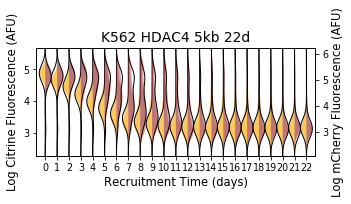

In [26]:
title = 'K562 HDAC4 5kb 22d'
cloneNames = ['H5KR2A-22d','H5KR3A-22d']
ylims = [(2.25,5.5),(2.5,6.25)]
offGates = (7000,10000)
fitsFile = 'K562_H5K_Final_Fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

### K562 HDAC No Spacer

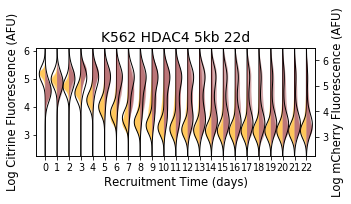

In [25]:
title = 'K562 HDAC4 NS 22d'
cloneNames = ['HNSR2A-22d','HNSR3A-22d']
ylims = [(2.25,5.25),(2.5,6.5)]
offGates = (7000,10000)
fitsFile = 'K562_HNS_Final_Fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

## plots with all data below

### K562 HDAC 5kb Spacer

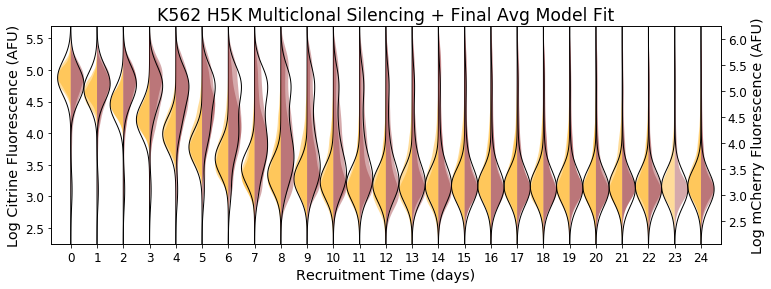

In [8]:
title = 'K562 H5K Multiclonal Silencing + Final Avg Model Fit'
cloneNames = ['H5KR2A','H5KR3A']
ylims = [(2.25,5.5),(2.5,6.25)]
offGates = (7000,10000)
fitsFile = 'K562_H5K_Final_Fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

### K562 HDAC No Spacer

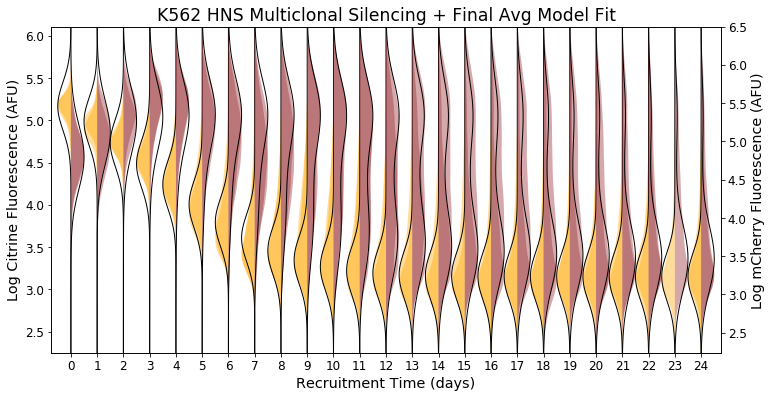

In [5]:
title = 'K562 HNS Multiclonal Silencing + Final Avg Model Fit'
cloneNames = ['HNSR2A','HNSR3A']
ylims = [(2.25,5.25),(2.5,6.5)]
offGates = (7000,10000)
fitsFile = 'K562_HNS_Final_Fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

### CHO HDAC 5kb Spacer

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: IntegrationWarning: The integral is probably divergent, or slowly convergent.


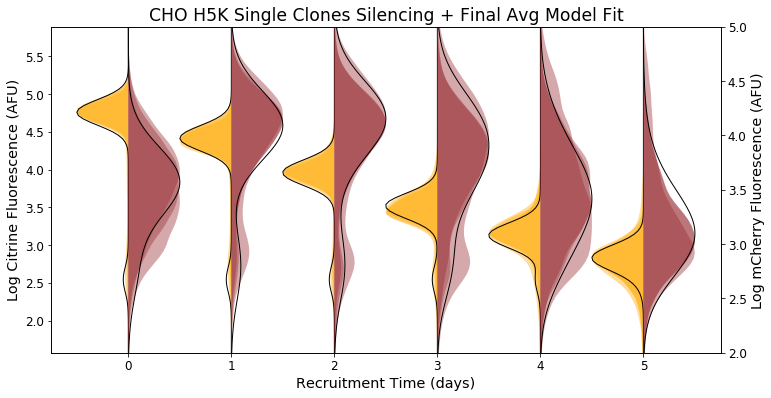

In [11]:
title = 'CHO H5K Single Clones Silencing + Final Avg Model Fit'
cloneNames = ['H5K1','H5K19','H5K24']
fitsFile = 'CHO_H5K_Final_Fits'
ylims = [(2,5.5),(2,5)]
offGates = (1850,1500)

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

### CHO HDAC No Spacer

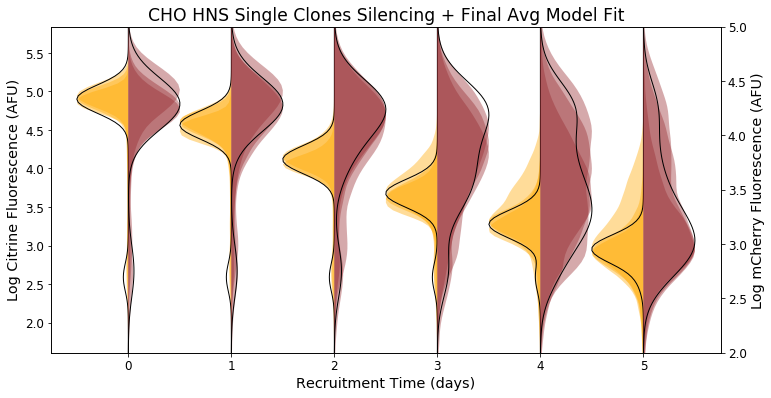

In [12]:
title = 'CHO HNS Single Clones Silencing + Final Avg Model Fit'
cloneNames = ['HNS3','HNS11','HNS15']
fitsFile = 'CHO_HNS_Final_Fits'
ylims = [(2,5.5),(2,5)]
offGates = (1850,1500)

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

### CHO HDAC 1.2kb Spacer

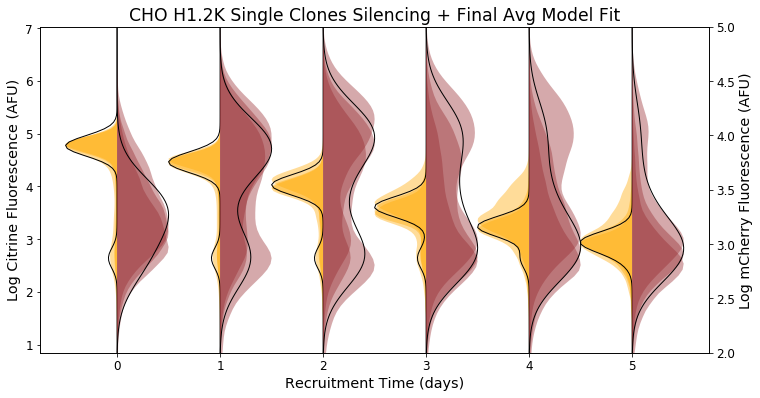

In [13]:
title = 'CHO H1.2K Single Clones Silencing + Final Avg Model Fit'
cloneNames = ['H1.2K1','H1.2K15','H1.2K16']
fitsFile = 'CHO_H1.2K_Final_Fits'
ylims = [(2,5.5),(2,5)]
offGates = (1850,1500)

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

### CHO HDAC Single HS4

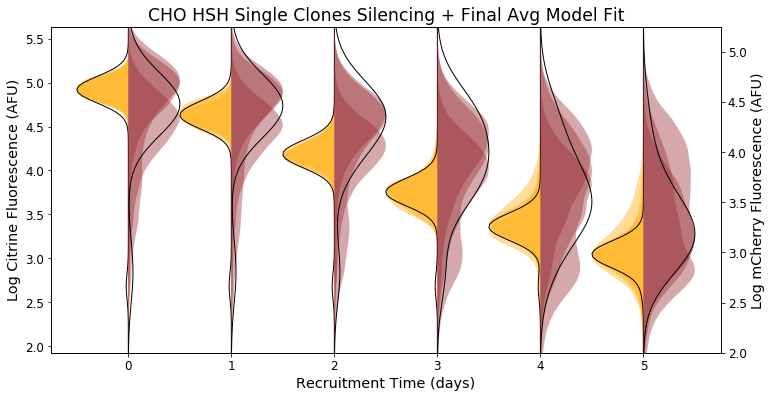

In [14]:
title = 'CHO HSH Single Clones Silencing + Final Avg Model Fit'
cloneNames = ['HSH9','HSH21','HSH26']
ylims = [(2,5.5),(2,5.25)]
offGates = (1850,1500)
fitsFile = 'CHO_HSH_Final_Fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

### CHO HDAC Single Core (MC)

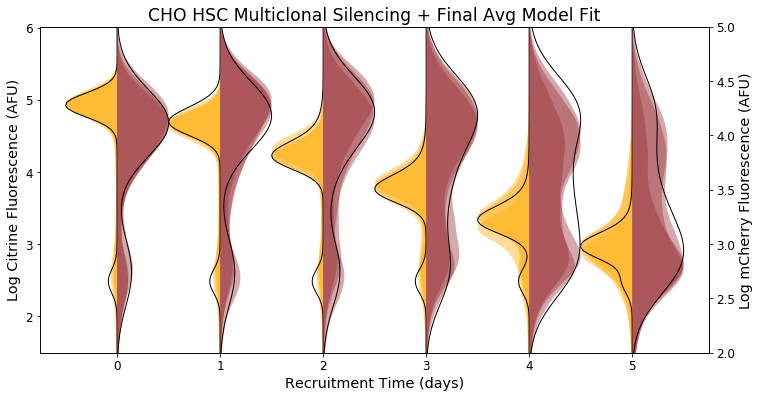

In [15]:
title = 'CHO HSC Multiclonal Silencing + Final Avg Model Fit'
cloneNames = ['HSC1','HSC2','HSC3']
ylims = [(1.5,5.5),(2,5)]
offGates = (1850,1500)
fitsFile = 'CHO_HSC_MC_Final_Fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

### CHO HDAC Double Core (MC)

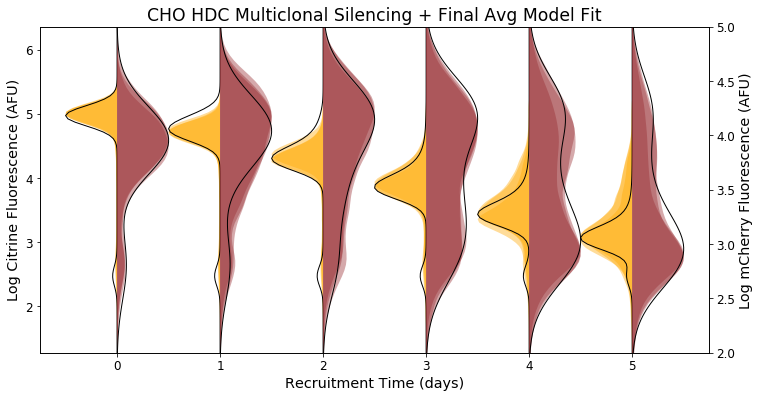

In [16]:
title = 'CHO HDC Multiclonal Silencing + Final Avg Model Fit'
cloneNames = ['HDC1','HDC2','HDC3']
ylims = [(2,5.5),(2,5)]
offGates = (1850,1500)
fitsFile = 'CHO_HDC_MC_Final_Fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

### CHO HDAC Single HS4 (MC)

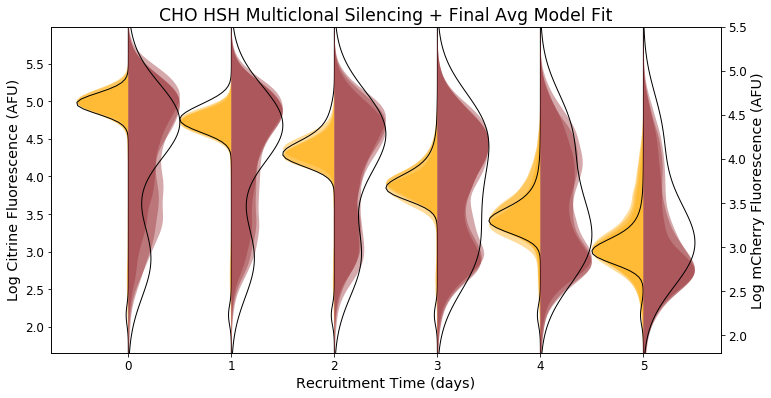

In [17]:
title = 'CHO HSH Multiclonal Silencing + Final Avg Model Fit'
cloneNames = ['HSH1','HSH2','HSH3']
ylims = [(2,5.5),(1.8,5.5)]
offGates = (1850,1500)
fitsFile = 'CHO_HSH_MC_Final_Fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

### CHO HDAC Double HS4 (MC)

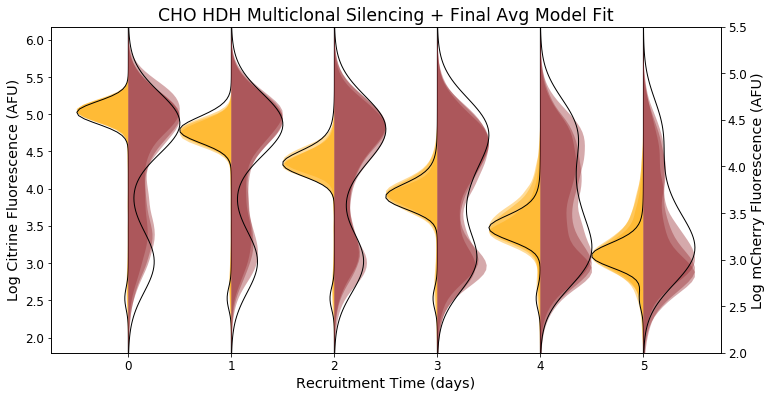

In [18]:
title = 'CHO HDH Multiclonal Silencing + Final Avg Model Fit'
cloneNames = ['HDH1','HDH2','HDH3']
ylims = [(2,5.5),(2,5.5)]
offGates = (1850,1500)
fitsFile = 'CHO_HDH_MC_Final_Fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

### CHO KRAB No Spacer

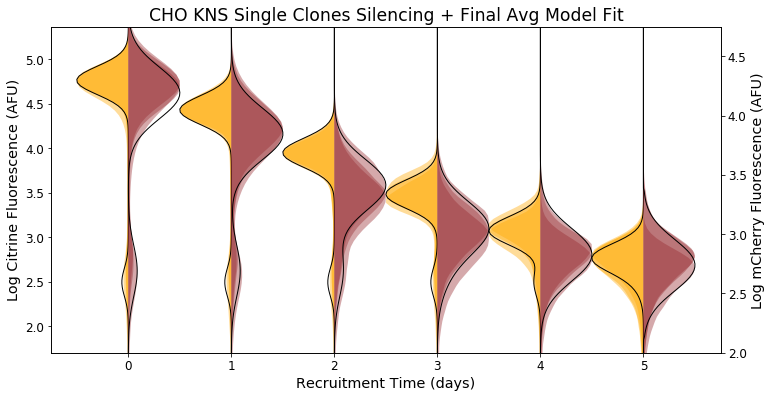

In [19]:
title = 'CHO KNS Single Clones Silencing + Final Avg Model Fit'
cloneNames = ['KNS1','KNS8','KNS10']
ylims = [(2,5.25),(2,4.75)]
fitsFile = 'CHO_KNS_Final_Fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

### CHO KRAB 1.2kb Spacer

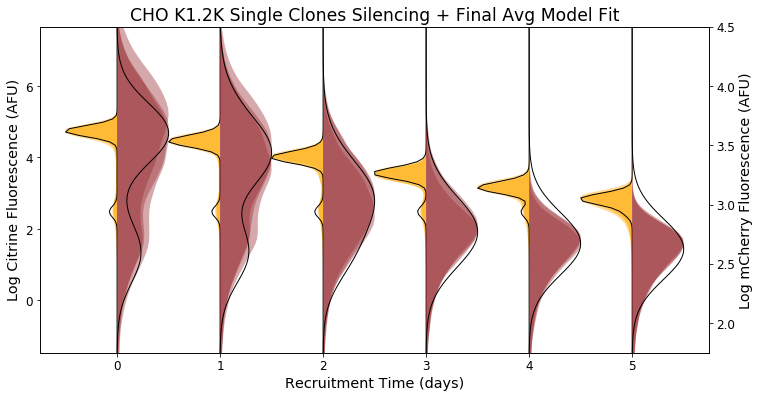

In [20]:
title = 'CHO K1.2K Single Clones Silencing + Final Avg Model Fit'
cloneNames = ['K1.2K4','K1.2K5','K1.2K15']
ylims = [(1.5,5.5),(1.75,4.5)]
offGates = (1850,1500)
fitsFile = 'CHO_K1.2K_Final_Fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

### CHO KRAB 5kb Spacer

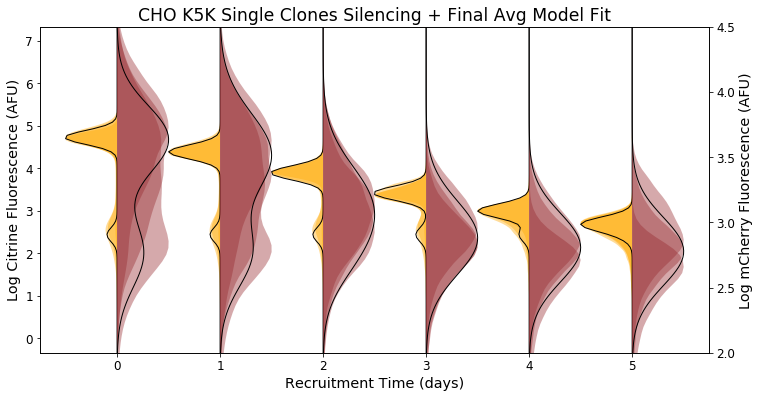

In [21]:
title = 'CHO K5K Single Clones Silencing + Final Avg Model Fit'
cloneNames = ['K5K24','K5K29','K5K40']
ylims = [(1.5,5.5),(2,4.5)]
offGates = (1850,1500)
fitsFile = 'CHO_K5K_Final_Fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

### K562 KRAB No Spacer (MC)

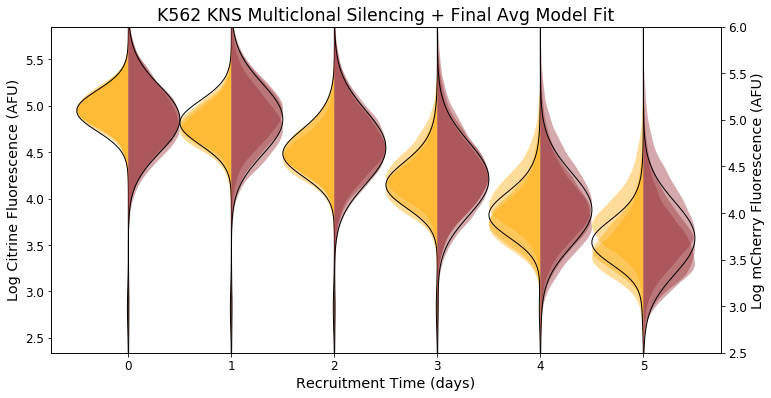

In [22]:
title = 'K562 KNS Multiclonal Silencing + Final Avg Model Fit'
cloneNames = ['KNSR1','KNSR2','KNSR3']
ylims = [(2.5,5.5),(2.5,6)]
offGates = (7000,10000)
fitsFile = 'K562_KNS_Final_Fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

### K562 KRAB 5kb Spacer (MC)

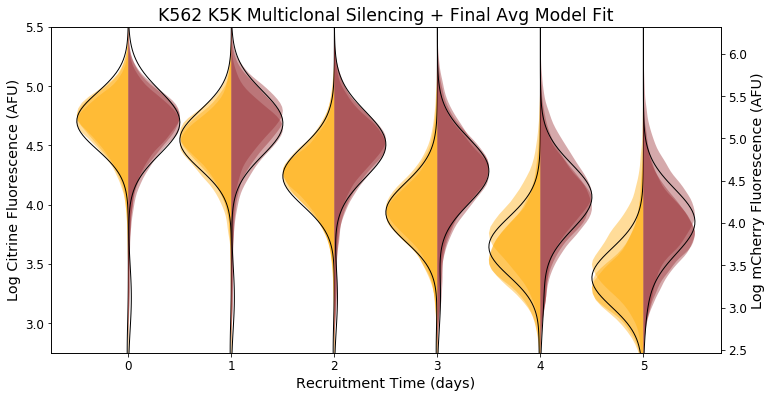

In [23]:
title = 'K562 K5K Multiclonal Silencing + Final Avg Model Fit'
cloneNames = ['K5KR1','K5KR2','K5KR3']
ylims = [(2.75,5.5),(2.75,6)]
offGates = (7000,10000)
fitsFile = 'K562_K5K_Final_Fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

### K562 KRAB Single Core (MC)

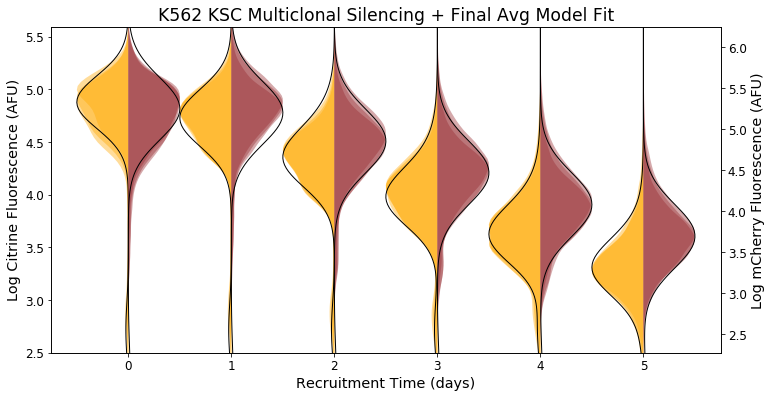

In [24]:
title = 'K562 KSC Multiclonal Silencing + Final Avg Model Fit'
cloneNames = ['KSCR1','KSCR2','KSCR3']
ylims = [(2.5,5.5),(2.5,6.25)]
offGates = (7000,10000)
fitsFile = 'K562_KSC_Final_Fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

### K562 KRAB Double Core (MC)

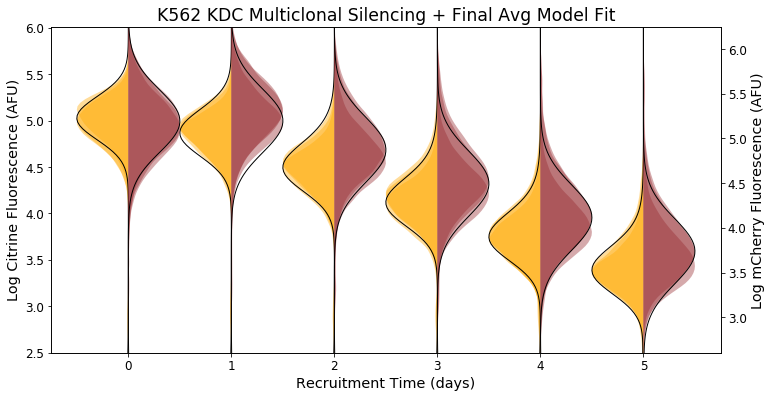

In [25]:
title = 'K562 KDC Multiclonal Silencing + Final Avg Model Fit'
cloneNames = ['KDCR1','KDCR2','KDCR3']
ylims = [(2.5,5.5),(2.75,6.25)]
offGates = (7000,10000)
fitsFile = 'K562_KDC_Final_Fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

### K562 KRAB Double Core Rev (MC)

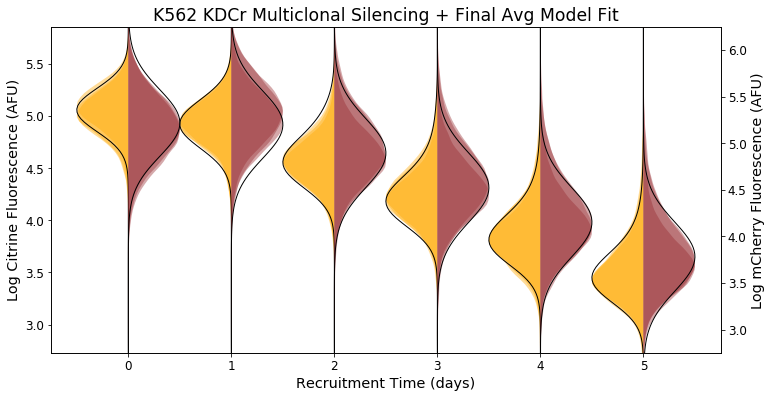

In [26]:
title = 'K562 KDCr Multiclonal Silencing + Final Avg Model Fit'
cloneNames = ['KDCrR1','KDCrR2','KDCrR3']
ylims = [(2.75,5.5),(2.75,6.25)]
offGates = (7000,10000)
fitsFile = 'K562_KDCr_Final_Fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

### K562 KRAB Single HS4 (MC)

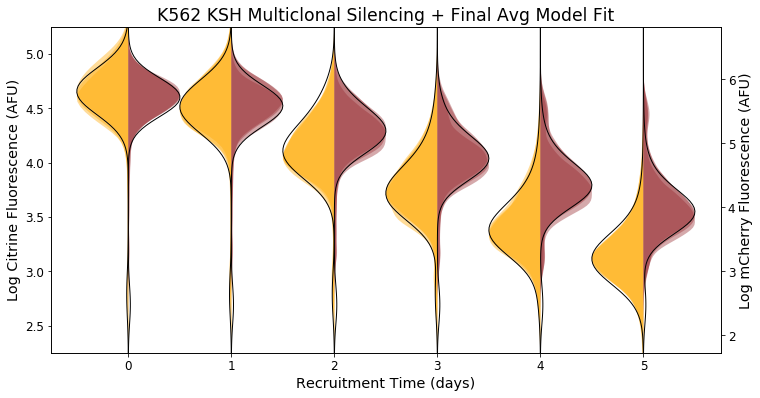

In [6]:
title = 'K562 KSH Multiclonal Silencing + Final Avg Model Fit'
cloneNames = ['KSHR1','KSHR2','KSHR3']
ylims = [(2.25,5.25),(2.5,6.25)]
offGates = (1000,1000)
fitsFile = 'K562_KSH_Final_Fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

### K562 KRAB Double HS4 (MC)

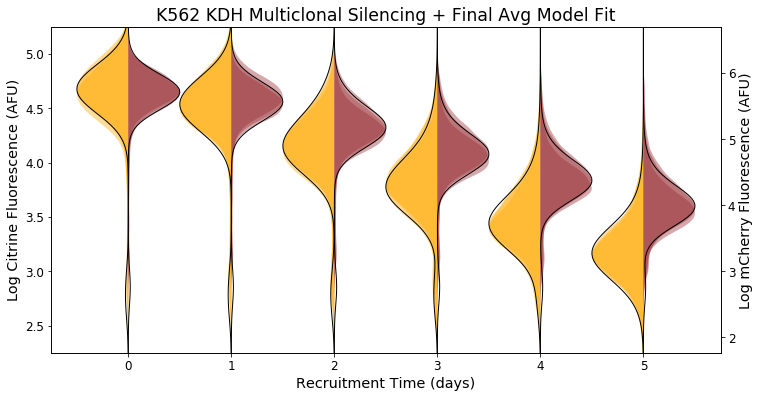

In [7]:
title = 'K562 KDH Multiclonal Silencing + Final Avg Model Fit'
cloneNames = ['KDHR1','KDHR2','KDHR3']
ylims = [(2.25,5.25),(2.5,6.5)]
offGates = (1000,1000)
fitsFile = 'K562_KDH_Final_Fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

### CHO KRAB Single Core (MC)

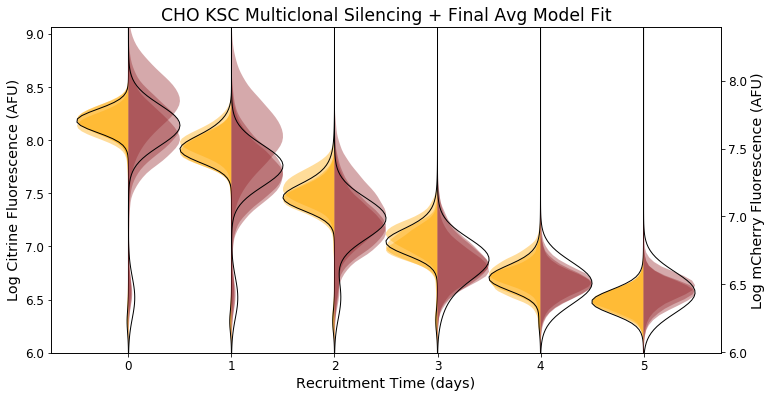

In [43]:
title = 'CHO KSC Multiclonal Silencing + Final Avg Model Fit'
cloneNames = ['KSC1','KSC2','KSC3']
ylims = [(6,8.5),(6,8.4)]
offGates = (1e7,6e6)
fitsFile = 'CHO_KSC_Final_Fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

### CHO KRAB Double Core (MC)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.


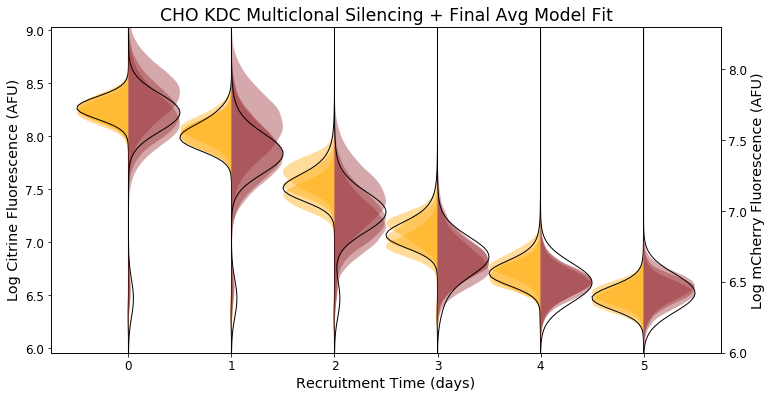

In [42]:
title = 'CHO KDC Multiclonal Silencing + Final Avg Model Fit'
cloneNames = ['KDC1','KDC2','KDC3']
ylims = [(6,8.5),(6,8.3)]
offGates = (1e7,6e6)
fitsFile = 'CHO_KDC_Final_Fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

### CHO KRAB Single HS4 (MC)

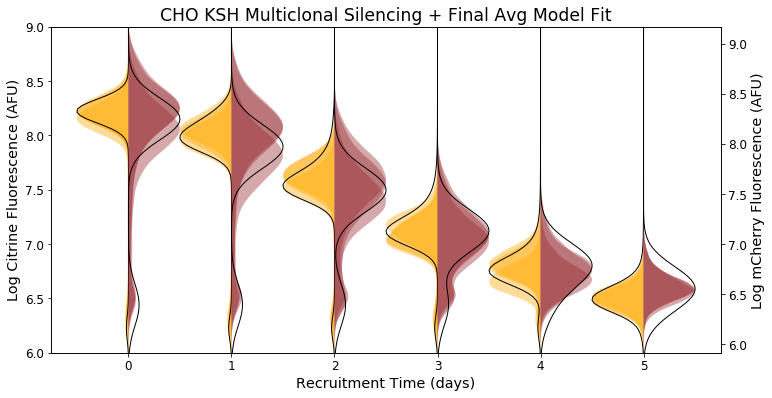

In [36]:
title = 'CHO KSH Multiclonal Silencing + Final Avg Model Fit'
cloneNames = ['KSH1','KSH2','KSH3']
ylims = [(6,9),(6,9)]
offGates = (1e7,1e7)
fitsFile = 'CHO_KSH_Final_Fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

### CHO KRAB Double HS4 (MC)

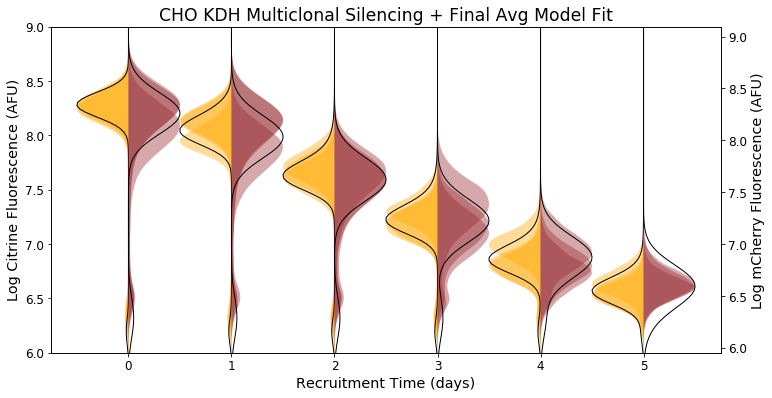

In [37]:
title = 'CHO KDH Multiclonal Silencing + Final Avg Model Fit'
cloneNames = ['KDH1','KDH2','KDH3']
ylims = [(6,9),(6,9)]
offGates = (1e7,1e7)
fitsFile = 'CHO_KDH_Final_Fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

In [58]:
# active state deterministic fluorescence
def F_o(t,a,b_p,g,F_b,sd):
    
    b_m = 4.159
    
    p_0 = a/(b_p*b_m*g)
    
    if t < sd:
        
        p = F_b + p_0
        
    else:
        
        p = F_b + (a/(b_p*b_m) + a*(1-1/g)*np.exp(-b_m*(t-sd))/(b_m**2-b_p*b_m) + 
                   (p_0 - a/(b_p*b_m) - a*(1-1/g)/(b_m**2-b_p*b_m))*np.exp(-b_p*(t-sd)))
    
    return p

# silent state deterministic fluorescence
def F_s(t,t_l,a,b_p,g,F_b,sd):
    
    b_m = 4.159
    
    p_0 = a/(b_p*b_m*g)
    
    p_t_l = (a/(b_p*b_m) + a*(1-1/g)*np.exp(-b_m*(t_l-sd))/(b_m**2-b_p*b_m) + 
             (p_0 - a/(b_p*b_m) - a*(1-1/g)/(b_m**2-b_p*b_m))*np.exp(-b_p*(t_l-sd)))
    
    if t_l < sd:
        
        p = F_b + ((p_0-a/((b_p-b_m)*b_m*g))*np.exp(-b_p*(t-t_l)) + a*np.exp(-b_m*(t-t_l))/((b_p-b_m)*b_m*g))
    
    else:
        
        p = F_b + ((p_t_l + a*(1-(1-1/g)*np.exp(-b_m*(t_l-sd)))/(b_m**2-b_p*b_m))*np.exp(-b_p*(t-t_l)) -
             a*(1-(1-1/g)*np.exp(-b_m*(t_l-sd)))/(b_m**2-b_p*b_m)*np.exp(-b_m*(t-t_l)))
        
    return p

# probability density funciton
def f(x,t,alpha,beta,gamma,sigma,k,mu,P_b,P_aa,F_b,sd):
    
    always_active = P_aa*stats.norm.pdf(x,np.log10(F_o(t,alpha,beta,gamma,F_b,sd)))
    
    background = P_b*stats.norm.pdf(x,np.log10(F_b),sigma)
    
    on = (1-P_b-P_aa)*(1-stats.gamma.cdf(t,k,scale=mu/k))*stats.norm.pdf(x,np.log10(F_o(t,alpha,beta,gamma,F_b,sd)),sigma)
    
    n = np.size(x)
    
    if n == 1:
        f_s = integrate.quad(lambda t_lag: 
                             stats.norm.pdf(x,np.log10(F_s(t,t_lag,alpha,beta,gamma,F_b,sd)),sigma)\
                             *stats.gamma.pdf(t_lag,k,scale=mu/k),0,t)[0]
    else:
        f_s = np.zeros(n)
        for i in np.arange(n):
            f_s[i] = integrate.quad(lambda t_lag: 
                                    stats.norm.pdf(x[i],np.log10(F_s(t,t_lag,alpha,beta,gamma,F_b,sd)),sigma)\
                                    *stats.gamma.pdf(t_lag,k,scale=mu/k),0,t)[0]
    
    silent = (1-P_b-P_aa)*f_s
    
    F = always_active + on + background + silent
    
    return F

## CHO HDAC4 low dox 1.2kb

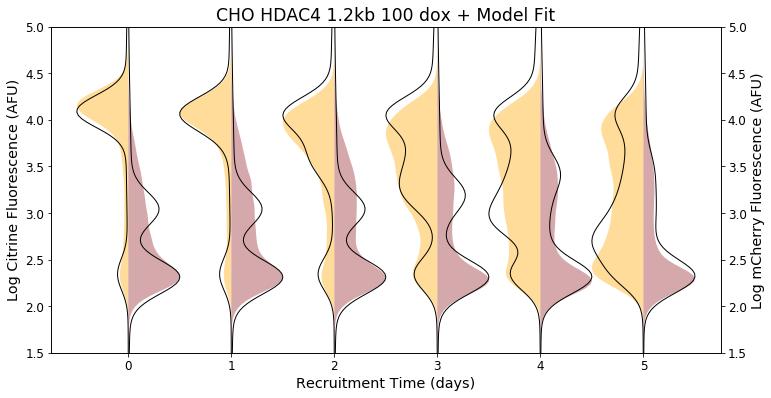

In [45]:
title = 'CHO HDAC4 1.2kb 100 dox + Model Fit'
cloneNames = ['h1.2K100']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HDAC4_1.2kb_100dox_fit'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

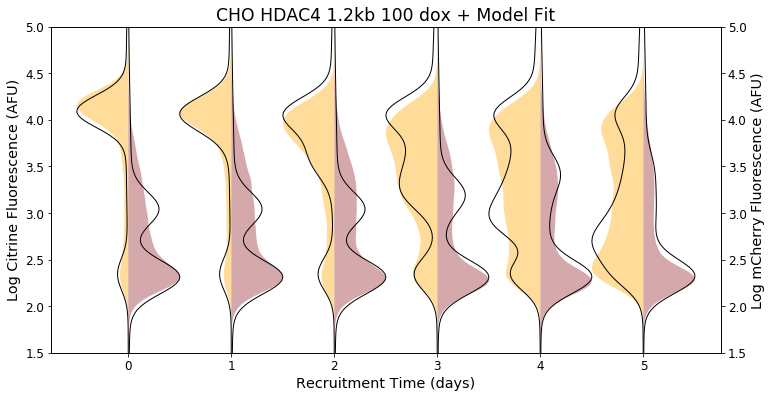

In [46]:
title = 'CHO HDAC4 1.2kb 100 dox + Model Fit' #with un-maxed out mch delay time
cloneNames = ['h1.2K100']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HDAC4_1.2kb_100dox_fit'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

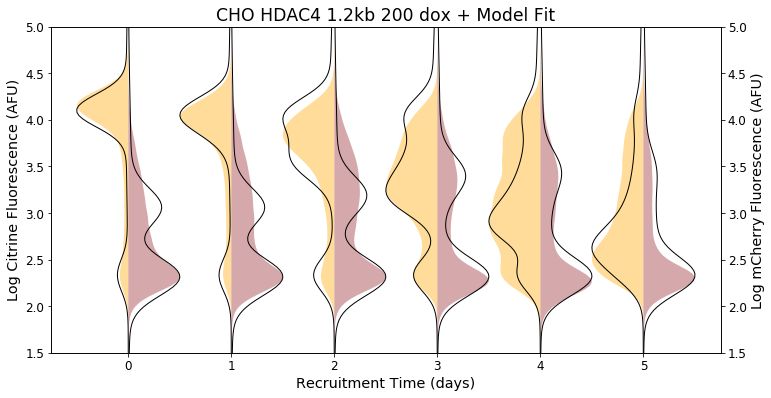

In [31]:
title = 'CHO HDAC4 1.2kb 200 dox + Model Fit'
cloneNames = ['h1.2K200']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HDAC4_1.2kb_200dox_fit'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

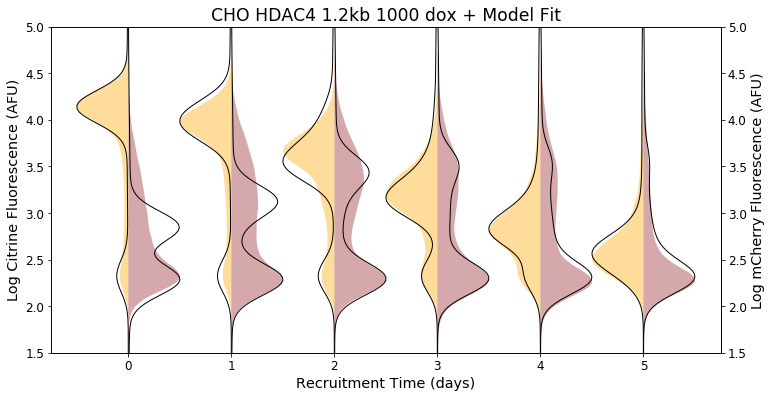

In [32]:
title = 'CHO HDAC4 1.2kb 1000 dox + Model Fit'
cloneNames = ['h1.2K1000']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HDAC4_1.2kb_1000dox_fit'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

## CHO HDAC4 low dox SC

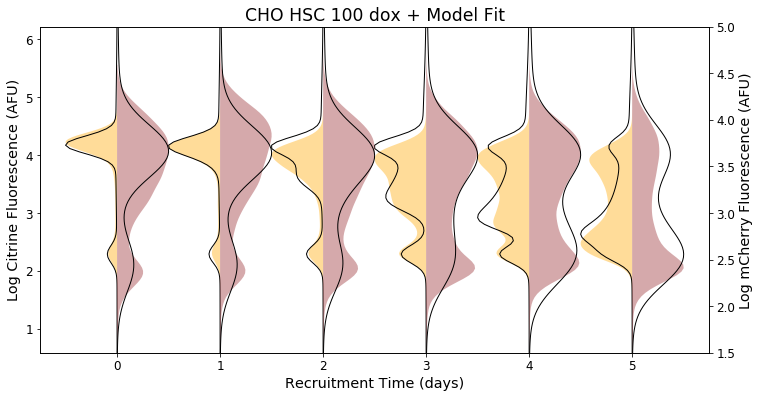

In [33]:
title = 'CHO HSC 100 dox + Model Fit'
cloneNames = ['hSC100']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HSC_100dox_fit'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

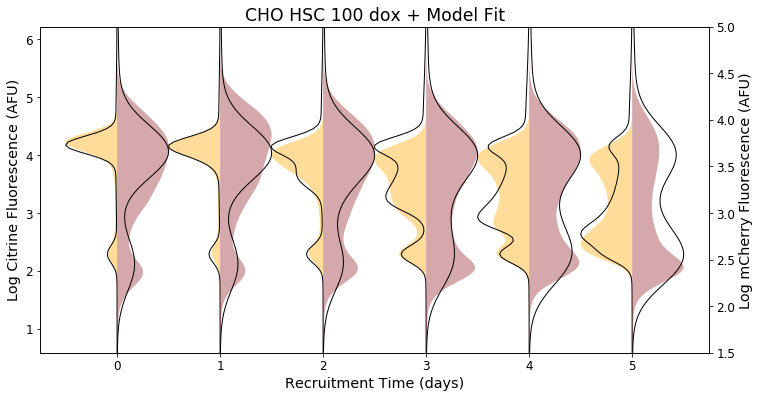

In [47]:
title = 'CHO HSC 100 dox + Model Fit' #with un-maxed out mch delay time
cloneNames = ['hSC100']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HSC_100dox_fit'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

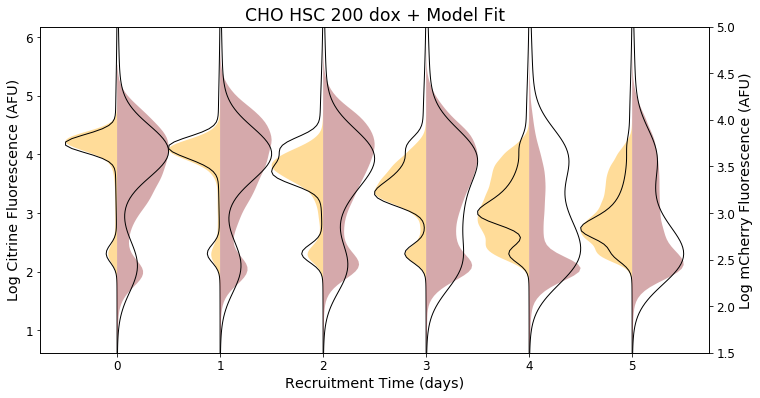

In [34]:
title = 'CHO HSC 200 dox + Model Fit'
cloneNames = ['hSC200']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HSC_200dox_fit'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

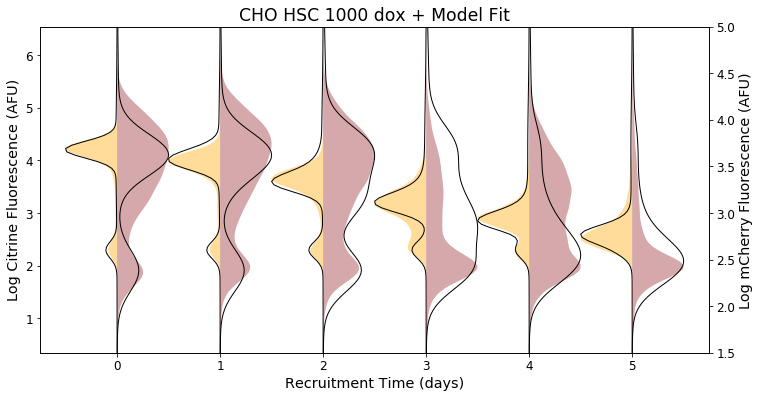

In [35]:
title = 'CHO HSC 1000 dox + Model Fit'
cloneNames = ['hSC1000']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HSC_1000dox_fit'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

## CHO HDAC4 low dox SH

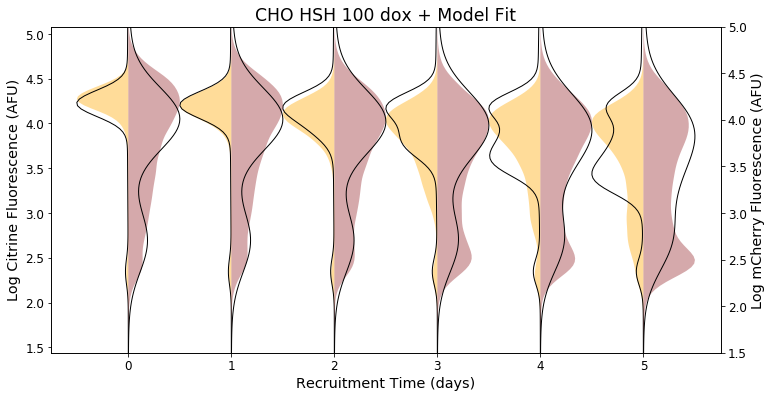

In [36]:
title = 'CHO HSH 100 dox + Model Fit'
cloneNames = ['hSH100']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HSH_100dox_fit'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

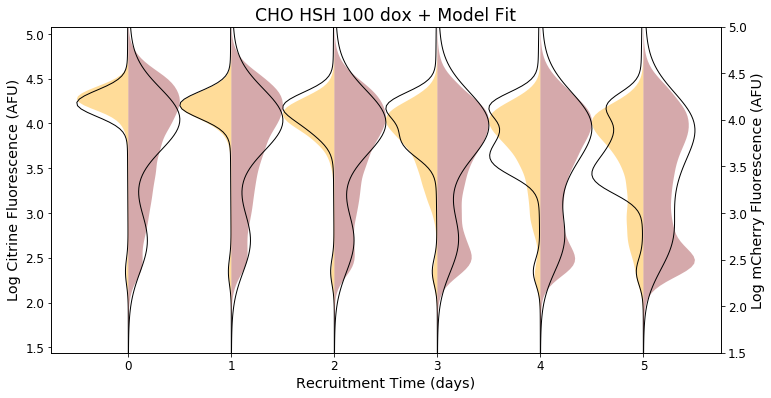

In [48]:
title = 'CHO HSH 100 dox + Model Fit' #with un-maxed out mch delay time
cloneNames = ['hSH100']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HSH_100dox_fit'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

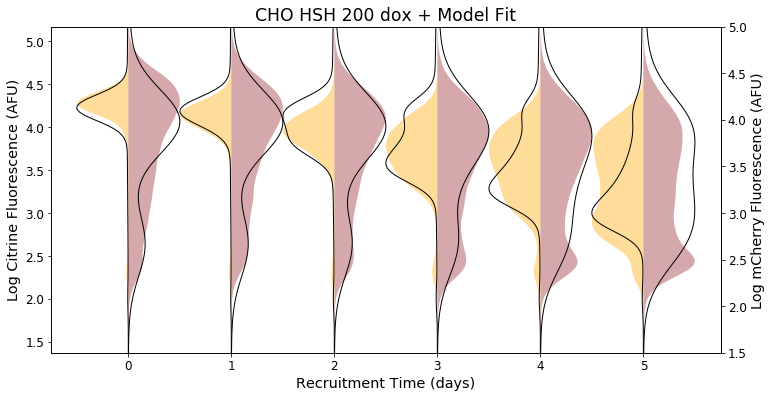

In [37]:
title = 'CHO HSH 200 dox + Model Fit'
cloneNames = ['hSH200']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HSH_200dox_fit'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

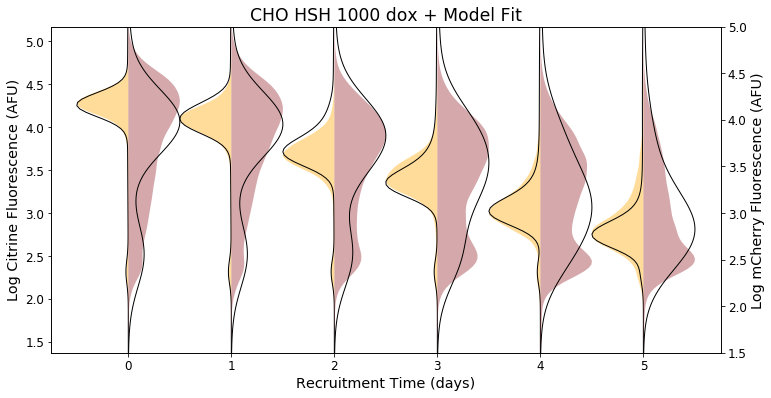

In [38]:
title = 'CHO HSH 1000 dox + Model Fit'
cloneNames = ['hSH1000']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HSH_1000dox_fit'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

## CHO HDAC4 low dox DC

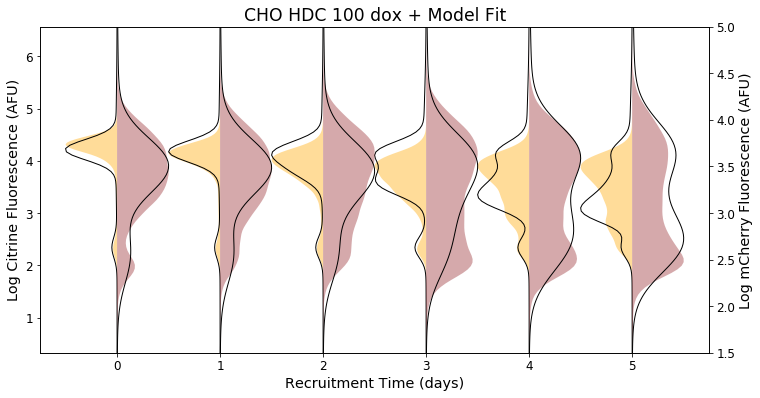

In [39]:
title = 'CHO HDC 100 dox + Model Fit'
cloneNames = ['hDC100']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HDC_100dox_fit'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

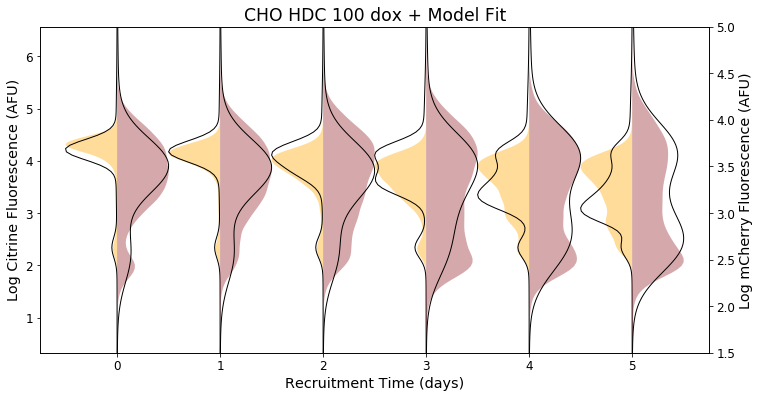

In [49]:
title = 'CHO HDC 100 dox + Model Fit'#with un-maxed out mch delay time
cloneNames = ['hDC100']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HDC_100dox_fit'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

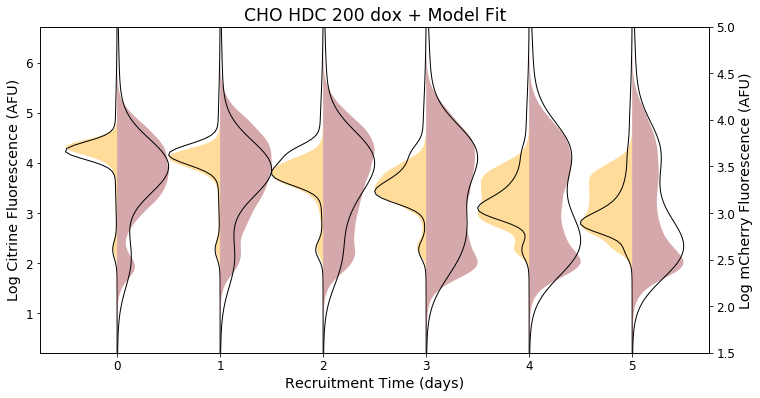

In [40]:
title = 'CHO HDC 200 dox + Model Fit'
cloneNames = ['hDC200']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HDC_200dox_fit'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

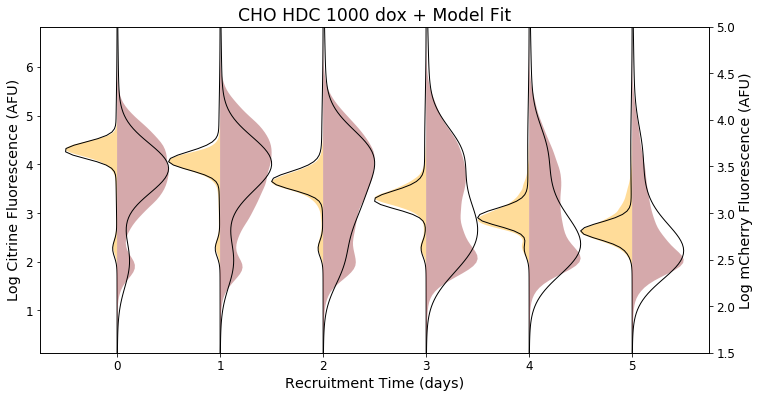

In [41]:
title = 'CHO HDC 1000 dox + Model Fit'
cloneNames = ['hDC1000']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HDC_1000dox_fit'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

## CHO HDAC4 low dox DH

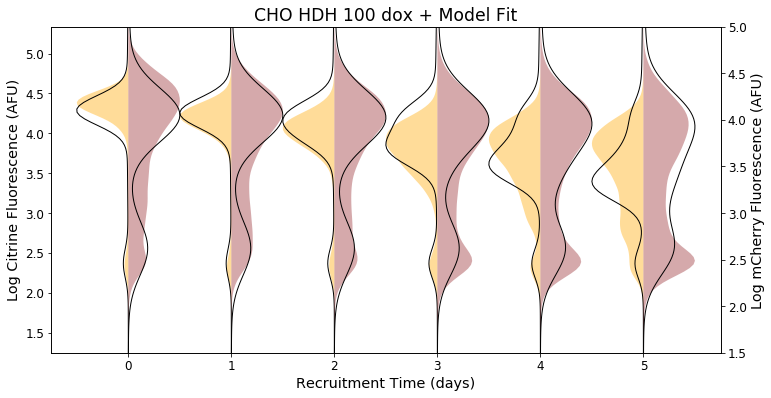

In [42]:
title = 'CHO HDH 100 dox + Model Fit'
cloneNames = ['hDH100']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HDH_100dox_fit'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

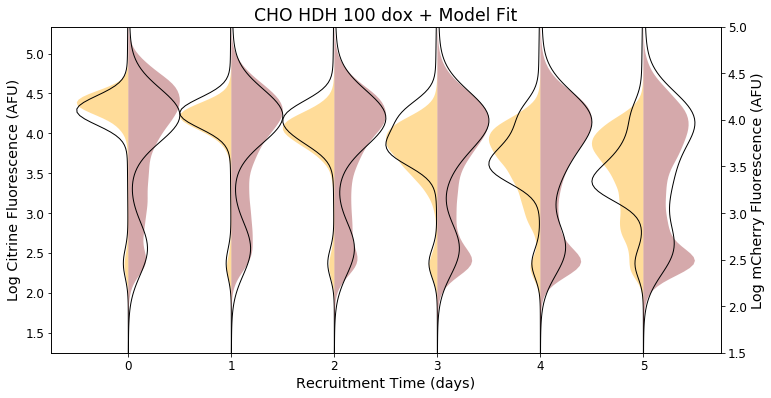

In [50]:
title = 'CHO HDH 100 dox + Model Fit' #with un-maxed out mch delay time
cloneNames = ['hDH100']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HDH_100dox_fit'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

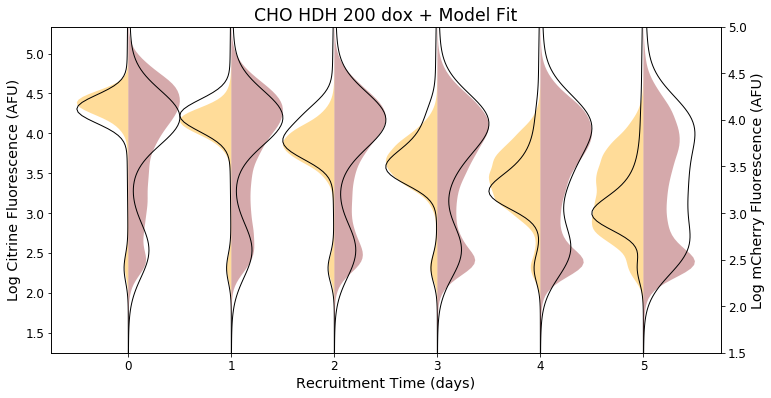

In [43]:
title = 'CHO HDH 200 dox + Model Fit'
cloneNames = ['hDH200']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HDH_200dox_fit'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

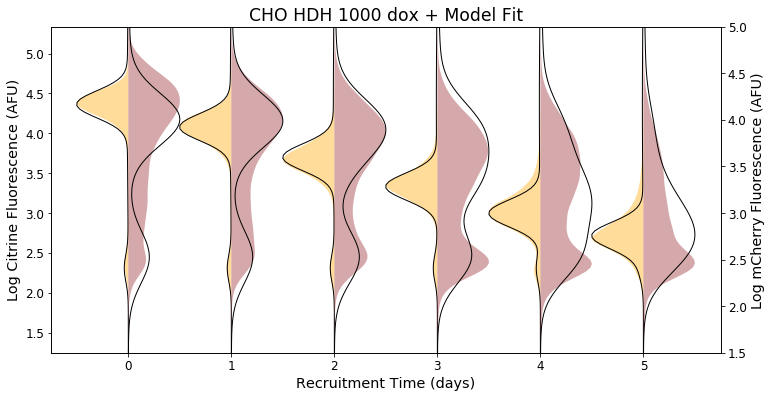

In [44]:
title = 'CHO HDH 1000 dox + Model Fit'
cloneNames = ['hDH1000']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HDH_1000dox_fit'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

## Combined replicates of low dox CHO HDAC4 ins

In [64]:
def combine_reps(line, R1_pkl, R2_pkl, R3_pkl, fits_pkl):
    R1 = pickle.load(open(R1_pkl, 'rb'))
    R1[0][line+'R1'] = R1[0][line]
    del R1[0][line]
    R1[1][line+'R1'] = R1[1][line]
    del R1[1][line]

    R2 = pickle.load(open(R2_pkl, 'rb'))
    R2[0][line+'R2'] = R2[0][line]
    del R2[0][line]
    R2[1][line+'R2'] = R2[1][line]
    del R2[1][line]

    R3 = pickle.load(open(R3_pkl, 'rb'))
    R3[0][line+'R3'] = R3[0][line]
    del R3[0][line]
    R3[1][line+'R3'] = R3[1][line]
    del R3[1][line]

    cit= {}
    cit.update(R1[0])
    cit.update(R2[0])
    cit.update(R3[0])

    mch= {}
    mch.update(R1[1])
    mch.update(R2[1])
    mch.update(R3[1])
    
    combined = (cit, mch)

    with open(fits_pkl, 'wb') as f:
        pickle.dump(combined, f)

In [70]:
combine_reps('hSC100', 'CHO_HDAC4_lowdox_R1_fits/CHO_HSC_100dox_fit.pkl', 'CHO_HDAC4_lowdox_R2/CHO_HSC_100dox_fit.pkl', 'CHO_HDAC4_lowdox_R3/CHO_HSC_100dox_fit.pkl','CHO_HSC_100dox_fits.pkl')
combine_reps('hSC200', 'CHO_HDAC4_lowdox_R1_fits/CHO_HSC_200dox_fit.pkl', 'CHO_HDAC4_lowdox_R2/CHO_HSC_200dox_fit.pkl', 'CHO_HDAC4_lowdox_R3/CHO_HSC_200dox_fit.pkl','CHO_HSC_200dox_fits.pkl')
combine_reps('hSC1000', 'CHO_HDAC4_lowdox_R1_fits/CHO_HSC_1000dox_fit.pkl', 'CHO_HDAC4_lowdox_R2/CHO_HSC_1000dox_fit.pkl', 'CHO_HDAC4_lowdox_R3/CHO_HSC_1000dox_fit.pkl','CHO_HSC_1000dox_fits.pkl')


In [76]:
combine_reps('hSH100', 'CHO_HDAC4_lowdox_R1_fits/CHO_hSH_100dox_fit.pkl', 'CHO_HDAC4_lowdox_R2/CHO_hSH_100dox_fit.pkl', 'CHO_HDAC4_lowdox_R3/CHO_hSH_100dox_fit.pkl','CHO_HSH_100dox_fits.pkl')
combine_reps('hSH200', 'CHO_HDAC4_lowdox_R1_fits/CHO_hSH_200dox_fit.pkl', 'CHO_HDAC4_lowdox_R2/CHO_hSH_200dox_fit.pkl', 'CHO_HDAC4_lowdox_R3/CHO_hSH_200dox_fit.pkl','CHO_HSH_200dox_fits.pkl')
combine_reps('hSH1000', 'CHO_HDAC4_lowdox_R1_fits/CHO_hSH_1000dox_fit.pkl', 'CHO_HDAC4_lowdox_R2/CHO_hSH_1000dox_fit.pkl', 'CHO_HDAC4_lowdox_R3/CHO_hSH_1000dox_fit.pkl','CHO_HSH_1000dox_fits.pkl')


In [72]:
combine_reps('hDC100', 'CHO_HDAC4_lowdox_R1_fits/CHO_hDC_100dox_fit.pkl', 'CHO_HDAC4_lowdox_R2/CHO_hDC_100dox_fit.pkl', 'CHO_HDAC4_lowdox_R3/CHO_hDC_100dox_fit.pkl','CHO_HDC_100dox_fits.pkl')
combine_reps('hDC200', 'CHO_HDAC4_lowdox_R1_fits/CHO_hDC_200dox_fit.pkl', 'CHO_HDAC4_lowdox_R2/CHO_hDC_200dox_fit.pkl', 'CHO_HDAC4_lowdox_R3/CHO_hDC_200dox_fit.pkl','CHO_HDC_200dox_fits.pkl')
combine_reps('hDC1000', 'CHO_HDAC4_lowdox_R1_fits/CHO_hDC_1000dox_fit.pkl', 'CHO_HDAC4_lowdox_R2/CHO_hDC_1000dox_fit.pkl', 'CHO_HDAC4_lowdox_R3/CHO_hDC_1000dox_fit.pkl','CHO_HDC_1000dox_fits.pkl')


In [73]:
combine_reps('hDH100', 'CHO_HDAC4_lowdox_R1_fits/CHO_hDH_100dox_fit.pkl', 'CHO_HDAC4_lowdox_R2/CHO_hDH_100dox_fit.pkl', 'CHO_HDAC4_lowdox_R3/CHO_hDH_100dox_fit.pkl','CHO_HDH_100dox_fits.pkl')
combine_reps('hDH200', 'CHO_HDAC4_lowdox_R1_fits/CHO_hDH_200dox_fit.pkl', 'CHO_HDAC4_lowdox_R2/CHO_hDH_200dox_fit.pkl', 'CHO_HDAC4_lowdox_R3/CHO_hDH_200dox_fit.pkl','CHO_HDH_200dox_fits.pkl')
combine_reps('hDH1000', 'CHO_HDAC4_lowdox_R1_fits/CHO_hDH_1000dox_fit.pkl', 'CHO_HDAC4_lowdox_R2/CHO_hDH_1000dox_fit.pkl', 'CHO_HDAC4_lowdox_R3/CHO_hDH_1000dox_fit.pkl','CHO_HDH_1000dox_fits.pkl')


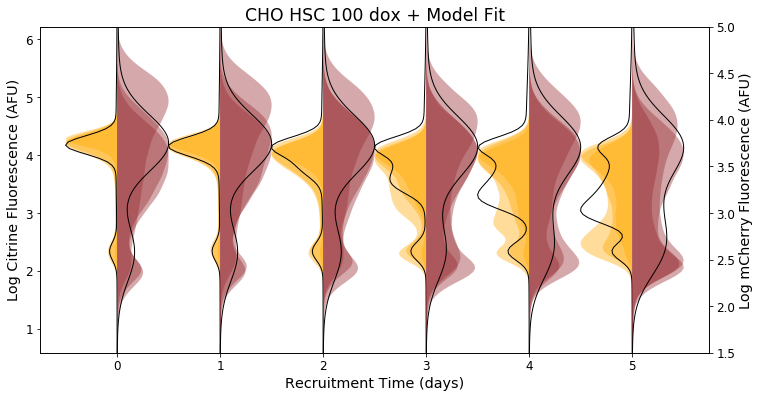

In [77]:
title = 'CHO HSC 100 dox + Model Fit'
cloneNames = ['hSC100','CHO_HDAC4_lowdox_R2/hSC100', 'CHO_HDAC4_lowdox_R3/hSC100']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HSC_100dox_fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

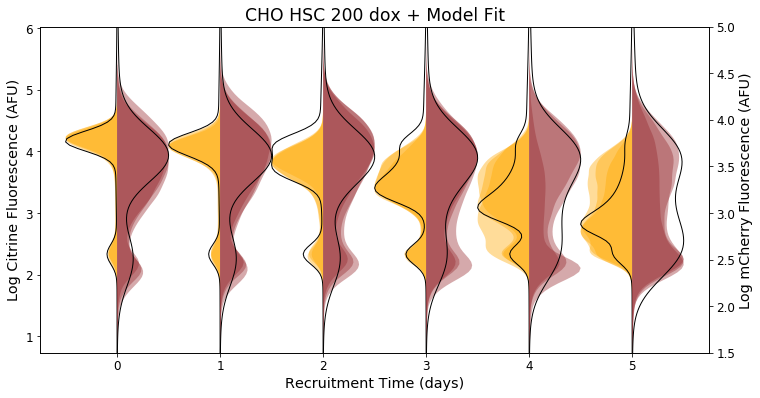

In [78]:
title = 'CHO HSC 200 dox + Model Fit'
cloneNames = ['hSC200','CHO_HDAC4_lowdox_R2/hSC200', 'CHO_HDAC4_lowdox_R3/hSC200']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HSC_200dox_fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

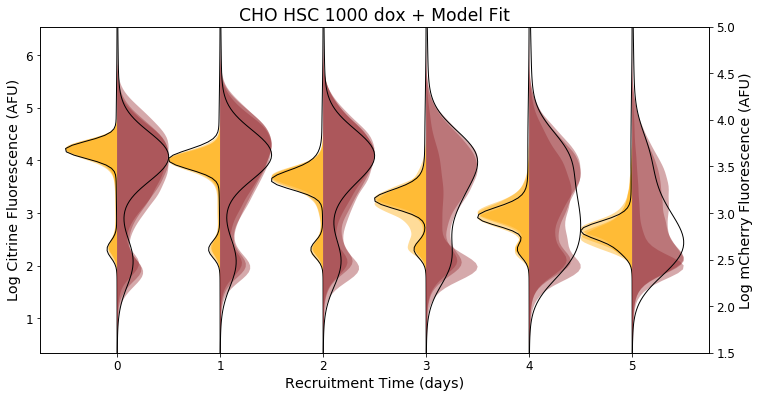

In [79]:
title = 'CHO HSC 1000 dox + Model Fit'
cloneNames = ['hSC1000','CHO_HDAC4_lowdox_R2/hSC1000', 'CHO_HDAC4_lowdox_R3/hSC1000']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HSC_1000dox_fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

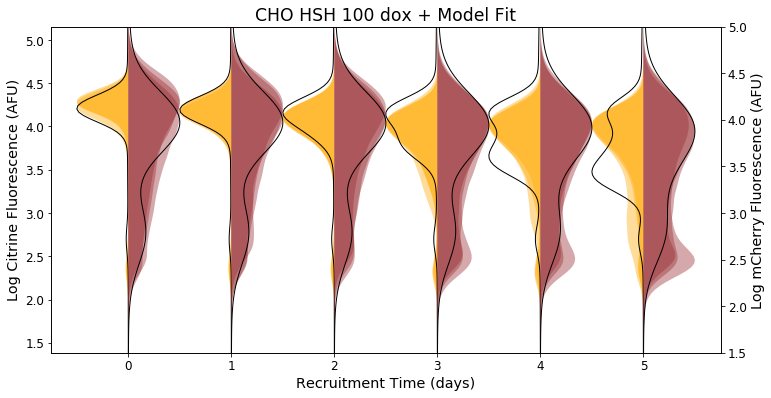

In [80]:
title = 'CHO HSH 100 dox + Model Fit'
cloneNames = ['hSH100','CHO_HDAC4_lowdox_R2/hSH100', 'CHO_HDAC4_lowdox_R3/hSH100']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HSH_100dox_fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

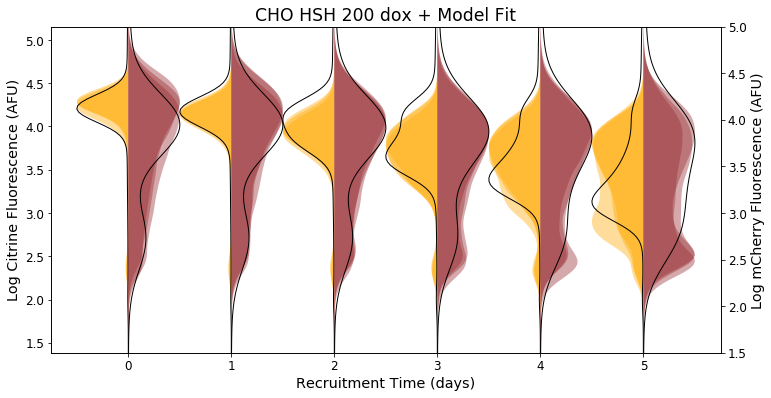

In [81]:
title = 'CHO HSH 200 dox + Model Fit'
cloneNames = ['hSH200','CHO_HDAC4_lowdox_R2/hSH200', 'CHO_HDAC4_lowdox_R3/hSH200']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HSH_200dox_fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

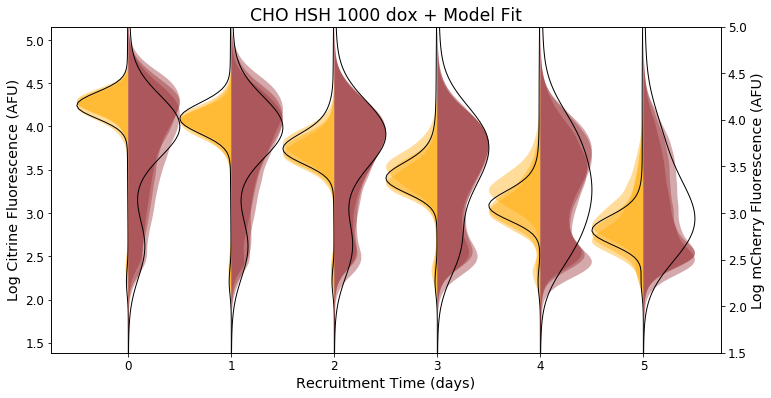

In [82]:
title = 'CHO HSH 1000 dox + Model Fit'
cloneNames = ['hSH1000','CHO_HDAC4_lowdox_R2/hSH1000', 'CHO_HDAC4_lowdox_R3/hSH1000']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HSH_1000dox_fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

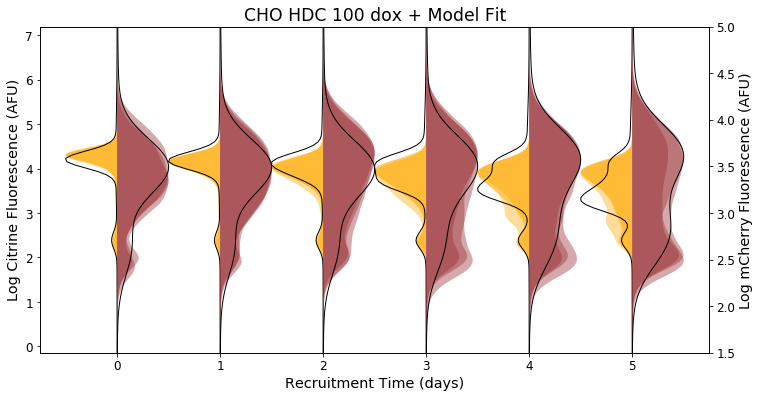

In [83]:
title = 'CHO HDC 100 dox + Model Fit'
cloneNames = ['hDC100','CHO_HDAC4_lowdox_R2/hDC100', 'CHO_HDAC4_lowdox_R3/hDC100']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HDC_100dox_fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

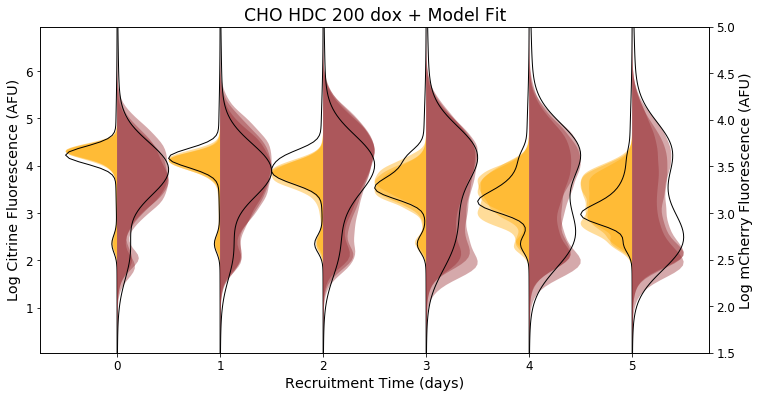

In [84]:
title = 'CHO HDC 200 dox + Model Fit'
cloneNames = ['hDC200','CHO_HDAC4_lowdox_R2/hDC200', 'CHO_HDAC4_lowdox_R3/hDC200']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HDC_200dox_fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

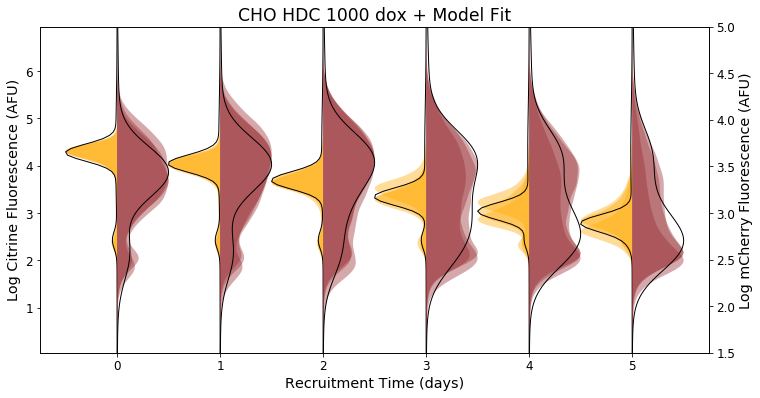

In [85]:
title = 'CHO HDC 1000 dox + Model Fit'
cloneNames = ['hDC1000','CHO_HDAC4_lowdox_R2/hDC1000', 'CHO_HDAC4_lowdox_R3/hDC1000']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HDC_1000dox_fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

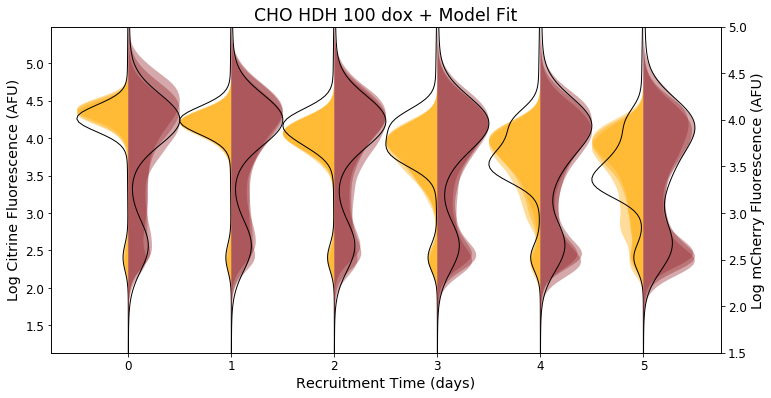

In [86]:
title = 'CHO HDH 100 dox + Model Fit'
cloneNames = ['hDH100','CHO_HDAC4_lowdox_R2/hDH100', 'CHO_HDAC4_lowdox_R3/hDH100']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HDH_100dox_fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

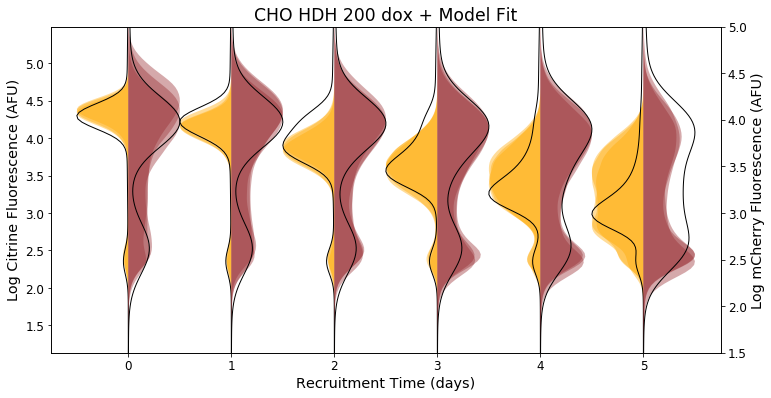

In [87]:
title = 'CHO HDH 200 dox + Model Fit'
cloneNames = ['hDH200','CHO_HDAC4_lowdox_R2/hDH200', 'CHO_HDAC4_lowdox_R3/hDH200']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HDH_200dox_fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)

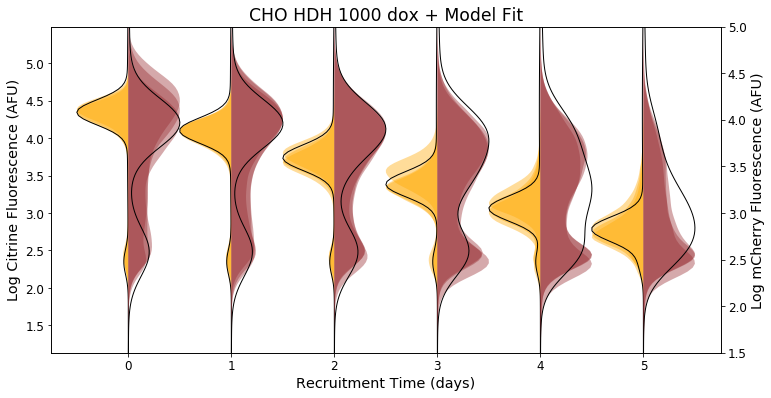

In [88]:
title = 'CHO HDH 1000 dox + Model Fit'
cloneNames = ['hDH1000','CHO_HDAC4_lowdox_R2/hDH1000', 'CHO_HDAC4_lowdox_R3/hDH1000']
ylims = [(1.5,5),(1.5,5)]
offGates = (1e3,1e3)
fitsFile = 'CHO_HDH_1000dox_fits'

halfViolinPlotwModel(cloneNames,title,ylims,offGates,fitsFile)